In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [2]:
torch.manual_seed(10)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
mean = 0.5
std_dev = 0.25

In [4]:
transform1 = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])

In [5]:
train_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = True,
    transform=transform2 #download is False in default
)

test_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = False,
    transform=transform2
)

In [6]:
len(train_data)

60000

In [7]:
num_epochs = 30
batch_size = 512
learning_rate = 1e-3

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

In [9]:
len(train_loader)

118

In [10]:
def imshow(img, label):
    img = img * std_dev + mean  # unnormalize
    plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[0]))
    plt.title(f'Label {label}')
    plt.show()

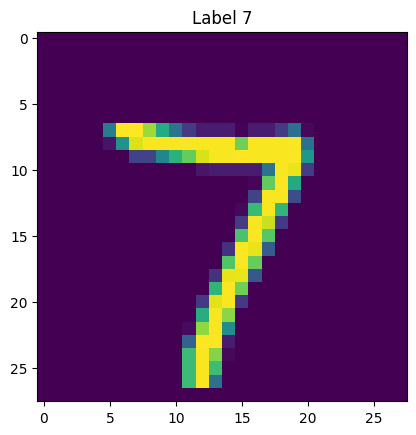

In [12]:
dataiter = next(iter(train_loader))
images, labels = dataiter
imshow(images[2],labels[2])

In [13]:
images.shape

torch.Size([512, 1, 28, 28])

In [14]:
class MyInceptionNetwork(nn.Module):
    def __init__(self) -> None:
        super(MyInceptionNetwork, self).__init__()
        self.conv11 = nn.Conv2d(1,16,3,1,'same')
        self.conv12 = nn.Conv2d(1,20,5,1,'same')
        self.conv13 = nn.Conv2d(1,12,7,1,'same')

        # Adding a Batch norm at every point, brings a HUGE IMPROVEMENT in ACCURACY 
        self.norm11 = nn.BatchNorm2d(12+20+16)
        self.conv1 = nn.Conv2d(12+20+16, 12+20+16, 1, 1) # 28, 28, 48
        self.norm12 = nn.BatchNorm2d(12+20+16)

        self.conv21 = nn.Conv2d(12+20+16, 64, 3, 2, 1)
        self.conv22 = nn.Conv2d(12+20+16, 32, 5, 2, 2)
        self.conv23 = nn.Conv2d(12+20+16, 16, 7, 2, 3)

        self.conv1to2 = nn.Conv2d(1, 64+32+16, 5, 2, 2)
        self.norm1to2 = nn.BatchNorm2d(64+32+16)

        self.norm21 = nn.BatchNorm2d(64+32+16)
        self.conv2 = nn.Conv2d(64+32+16, 64+32+16, 1, 1) # 14, 14, 112
        self.norm22 = nn.BatchNorm2d(64+32+16)

        self.conv31 = nn.Conv2d(64+32+16, 100, 1, 1, 0)
        self.conv32 = nn.Conv2d(64+32+16, 100, 3, 1, 1)
        self.conv33 = nn.Conv2d(64+32+16, 50, 5, 1, 2)
        self.conv34 = nn.Conv2d(64+32+16, 50, 7, 1, 3)
        self.maxpool1 = nn.MaxPool2d(3,1,padding = 1) # Stride = 1
        self.conv_maxpool = nn.Conv2d(64+32+16, 32, 1, 1, 0)

        self.conv1to3 = nn.Conv2d(1, 332, 5, 2, 2)
        self.norm1to3 = nn.BatchNorm2d(332)

        self.norm31 = nn.BatchNorm2d(332)
        self.conv3 = nn.Conv2d(332, 332, 7, 2) # 4, 4, 332
        self.norm32 = nn.BatchNorm2d(332)

        self.conv1to4 = nn.Conv2d(1, 332, 9, 5, 0)
        self.norm1to4 = nn.BatchNorm2d(332)

        self.maxpool_final = nn.MaxPool2d(2,2) # 2, 2, 332

        self.linear1 = nn.Linear(332*4,500)
        self.norm4 = nn.BatchNorm1d(500)
        self.linear2 = nn.Linear(500,100)
        self.norm5 = nn.BatchNorm1d(100)
        self.linear3 = nn.Linear(100,10)

    def forward(self, x):
        x_temp = x

        x1 = torch.relu(self.conv11(x))
        x2 = torch.relu(self.conv12(x))
        x3 = torch.relu(self.conv13(x))
        x = x1
        x = torch.cat((x,x2),1)
        x = torch.cat((x,x3),1)

        x = self.norm12(torch.relu(self.conv1(self.norm11(x))))

        x1 = torch.relu(self.conv21(x))
        x2 = torch.relu(self.conv22(x))
        x3 = torch.relu(self.conv23(x))
        x = x1
        x = torch.cat((x,x2),1)
        x = torch.cat((x,x3),1)

        x = self.norm22(torch.relu(self.conv2(self.norm21(x) + self.norm1to2(torch.relu(self.conv1to2(x_temp))))))

        x1 = torch.relu(self.conv31(x))
        x2 = torch.relu(self.conv32(x))
        x3 = torch.relu(self.conv33(x))
        x4 = torch.relu(self.conv34(x))
        x5 = torch.relu(self.conv_maxpool(self.maxpool1(x)))
        x = x1
        x = torch.cat((x,x2),1)
        x = torch.cat((x,x3),1)
        x = torch.cat((x,x4),1)
        x = torch.cat((x,x5),1)

        x = self.maxpool_final(self.norm32(torch.relu(self.conv3(self.norm31(x) + self.norm1to3(torch.relu(self.conv1to3(x_temp)))))) + self.norm1to4(torch.relu(self.conv1to4(x_temp))))

        x = torch.flatten(x, 1)

        x = self.norm4(torch.relu(self.linear1(x)))
        x = self.norm5(torch.relu(self.linear2(x)))
        x = torch.relu(self.linear3(x))

        return(x)

In [15]:
incresnet = MyInceptionNetwork().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(incresnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma = 0.5)

In [17]:
summary(copy.deepcopy(incresnet).to('cpu'), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 20, 28, 28]             520
            Conv2d-3           [-1, 12, 28, 28]             600
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 48, 28, 28]           2,352
       BatchNorm2d-6           [-1, 48, 28, 28]              96
            Conv2d-7           [-1, 64, 14, 14]          27,712
            Conv2d-8           [-1, 32, 14, 14]          38,432
            Conv2d-9           [-1, 16, 14, 14]          37,648
      BatchNorm2d-10          [-1, 112, 14, 14]             224
           Conv2d-11          [-1, 112, 14, 14]           2,912
      BatchNorm2d-12          [-1, 112, 14, 14]             224
           Conv2d-13          [-1, 112, 14, 14]          12,656
      BatchNorm2d-14          [-1, 112,

In [18]:
best_weights = copy.deepcopy(incresnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    incresnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = incresnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        incresnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = incresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(incresnet.state_dict())
        
        if((epoch+1) % 10 == 0):
            n_samples = 0
            n_correct = 0
            
            for images, labels in train_loader:
                images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
                labels = labels.to(device)
                pred_outputs1 = incresnet(images)
                _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
                n_samples += labels.shape[0]
                n_correct += (actual_preds1 == labels).sum().item()
            train_acc = n_correct/n_samples * 100
            print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Best Test Accuracy = {max}%')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

Epoch 1/30; Loss = 0.031976; LR = [0.001]
SAVED MODEL WEIGHTS
Dev Accuracy: 98.32%
--------------------
Epoch 2/30; Loss = 0.030722; LR = [0.001]
SAVED MODEL WEIGHTS
Dev Accuracy: 98.69%
--------------------
Epoch 3/30; Loss = 0.004341; LR = [0.001]
SAVED MODEL WEIGHTS
Dev Accuracy: 99.11%
--------------------
Epoch 4/30; Loss = 0.001211; LR = [0.001]
SAVED MODEL WEIGHTS
Dev Accuracy: 99.32%
--------------------
Epoch 5/30; Loss = 0.054655; LR = [0.001]
Dev Accuracy: 99.09%
--------------------
Epoch 6/30; Loss = 0.001523; LR = [0.0005]
Dev Accuracy: 98.86%
--------------------
Epoch 7/30; Loss = 0.000384; LR = [0.0005]
SAVED MODEL WEIGHTS
Dev Accuracy: 99.35%
--------------------
Epoch 8/30; Loss = 0.000256; LR = [0.0005]
SAVED MODEL WEIGHTS
Dev Accuracy: 99.39%
--------------------
Epoch 9/30; Loss = 0.000406; LR = [0.0005]
SAVED MODEL WEIGHTS
Dev Accuracy: 99.42%
--------------------
Epoch 10/30; Loss = 0.000311; LR = [0.0005]
SAVED MODEL WEIGHTS
Train Accuracy: 100.00%
Dev Accuracy

KeyboardInterrupt: 

No improvement at all, performance in pure inception network is better

In [18]:
incresnet.load_state_dict(best_weights)
torch.save(incresnet, 'models/simple_incresnet_mnist.pt')

In [19]:
incresnet.eval()
for images, labels in train_loader: # Train Accuracy
    images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
    labels = labels.to(device)
    pred_outputs1 = incresnet(images)
    _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
    n_samples += labels.shape[0]
    n_correct += (actual_preds1 == labels).sum().item()
train_acc = n_correct/n_samples * 100
print(f'Training Accuracy = {train_acc:.2f}%')


Training Accuracy = 100.00%
